# Introduction to Machine Learning
## Home Assignment 1
## Imports

In [2]:
import requests
from zipfile import ZipFile
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

## Data Preporcessing

In [3]:
# we get the data
_URL = 'http://www.di.ens.fr/appstat/spring-2020/project/data2.zip'
r = requests.get(_URL, allow_redirects=True)
with open('data2.zip', 'wb') as f:
    f.write(r.content)
with ZipFile('data2.zip', 'r') as zipObj:
    zipObj.extractall()


In [4]:
training_data_path = os.path.join('data2', 'train')
test_data_path = os.path.join('data2', 'test')

In [5]:

number_of_samples_per_letter = 300
pixel_height = 28
pixel_width = 28
number_of_pixels = pixel_height*pixel_width
batch_size = 50
shape = (pixel_height*pixel_width)
seed = 54
# We define a flow of images: 

def generate (dir_path): 
    training_data = []
    training_labels = []
    for item in os.listdir(dir_path):
        tmp = os.path.join(dir_path,item)
        if os.path.isdir(tmp):
            d, l = generate (tmp)
            training_data = training_data + d
            training_labels = training_labels + l
        elif tmp[-3:] == "png":
            im = Image.open(tmp)
            training_data.append(np.reshape(np.asarray(im), shape))
            if(dir_path[-1:] == 'A'):
                training_labels.append(1)
            else: 
                training_labels.append(-1)
    return training_data, training_labels





            
def make (dir_path): 
    d, l = generate(dir_path)
    data = np.array(d)/255
    label = np.reshape(np.array(l), (np.shape(l)[0],1))
    L = np.arange(np.shape(data)[0])
    random.shuffle(L)
    return data[L], label[L]


training_data, training_labels = make(training_data_path)
test_data, test_labels = make(test_data_path)


print(np.shape(training_data))
print(np.shape(training_labels))

(900, 784)
(900, 1)


## Utility functions 

In [6]:
def logistic_loss_lasso (theta, x, y, lambd): 
    return 1/np.shape(y)[0] * np.sum(np.log(1+np.exp(-y*(x@theta))), axis=0) + lambd*np.sum(np.abs(theta), axis=0)


def S_lambda (x, lambd):
    if (np.abs(x) <= lambd):
        return 0
    return x - lambd*np.sign(x)
    
#need to update it with logistic partial derivative not the OLS one
def update_i_coordinate_lasso (theta, x, y, lambd, i):
    x_i_T = np.reshape(x[:,i], (1, np.shape(y)[0]))
    if (i > 0 and i < number_of_pixels):
        x__i = np.hstack([x[:,:i], x[:,i+1:]])
        theta_i = np.concatenate([theta[:i], theta[i+1:]])
    elif (i == 0):
        x__i  = x[:, 1:]
        theta_i = theta[1:]
    else: 
        x__i = x[:, :(number_of_pixels - 1)]
        theta_i = theta[:(number_pixels - 1)]
    a = S_lambda(x_i_T@(y-(x_i_T@x__i@theta_i)), lambd)/(x_i_T@np.reshape(x[:,i], (np.shape(y)[0], 1)))
    print(a)
    return a
    
    
def logistic_loss_ridge (theta, x, y, lambd): 
    return 1/np.shape(y)[0] * np.sum(np.log(1+np.exp(-y*(x@theta))), axis=0) + lambd*np.sum(theta**2, axis=0)

def logistic_gradient_ridge (theta, x, y, lambd):
    k = -y*x
    e = np.exp(k@theta)
    u_ = k*e
    return np.reshape(1/np.shape(y)[0] * np.sum(u_/(1+e), axis=0), np.shape(theta)) + lambd*2*theta

def sigmoid(t):
    return 1/(1 + np.exp(-t))       

def logistic_classify(theta, data): 
    return 2*(sigmoid(data@theta)>0.5) - 1

def test(theta, data_set, labels): 
    accuracy = 0
    for x, y in zip (data_set, labels):
        accuracy += (logistic_classify(theta, x) == y) 
    return accuracy/len(labels)

def plot(training_error, test_error, t, t_s, title):
    plt.plot(t, training_error, label="training_error")
    plt.plot(t, test_error, label="test_error")
    plt.legend()
    plt.ylabel("error_rate")
    plt.xlabel(t_s)
    plt.title(title)
    plt.show(block=False)
    



## Gradient Descent and Coordinate Desecent

In [7]:
def gradient_descent_ridge (starting_point, training_data, training_labels, eta, t, lambd):
    theta = starting_point
    for i in range (t):
        delta_theta = -logistic_gradient_ridge(theta, training_data, training_labels, lambd)
        theta += eta*delta_theta
    return theta

def coordinate_descent_lasso (starting_point, training_data, training_labels, eta, t, lambd):
    theta = starting_point
    for j in range(t):
        for i in range(number_of_pixels):
            theta[i, 0] = update_i_coordinate_lasso(theta, training_data, training_labels, lambd, i)[0, 0]
    return theta

[0.93466667]
[0.936]
[0.936]
[0.936]
[0.936]
[0.93466667]
[0.936]
[0.93466667]
[0.93733333]
[0.93466667]
[0.93466667]
[0.93333333]
[0.93333333]
[0.93066667]
[0.93066667]
[0.93066667]
[0.93066667]
[0.92933333]
[0.92666667]
[0.92666667]
[0.92666667]
[0.92266667]
[0.92266667]
[0.92133333]
[0.92]
[0.91866667]
[0.91866667]
[0.91866667]
[0.91733333]
[0.91733333]
[0.91466667]
[0.91466667]
[0.91466667]
[0.912]
[0.912]
[0.912]
[0.90933333]
[0.90666667]
[0.90533333]
[0.90533333]
[0.90533333]
[0.90533333]
[0.90533333]
[0.904]
[0.904]
[0.90266667]
[0.90133333]
[0.9]
[0.89733333]
[0.89733333]
[0.896]
[0.896]
[0.89466667]
[0.89333333]
[0.892]
[0.89066667]
[0.89066667]
[0.888]
[0.888]
[0.888]
[0.88666667]
[0.88666667]
[0.884]
[0.88]
[0.88]
[0.87733333]
[0.87733333]
[0.87866667]
[0.87866667]
[0.876]
[0.87333333]
[0.87333333]
[0.872]
[0.87066667]
[0.86666667]
[0.86666667]
[0.86666667]
[0.86666667]
[0.86666667]
[0.86666667]
[0.864]
[0.864]
[0.864]
[0.86266667]
[0.86133333]
[0.85866667]
[0.85733333]
[0.8

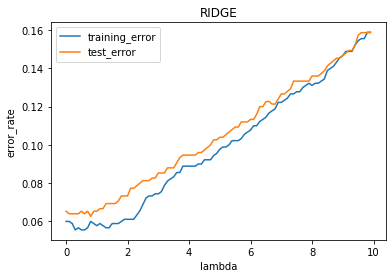

In [8]:
def evaluate (descent, title):
    training_errors = []
    test_errors = []
    lambdas = np.arange(0, 10, 0.1)
    for lambd in lambdas:
        theta = descent(0.001*np.ones((pixel_height*pixel_width, 1)), training_data, training_labels, 0.01, 100, lambd)
        tmp = test(theta, test_data, test_labels)
        print(tmp)
        training_errors.append(test(theta, training_data, training_labels))
        test_errors.append(tmp)


    plot(1-np.array(training_errors), 1-np.array(test_errors), lambdas, "lambda", title)
    
    
#evaluate(coordinate_descent_lasso, "LASSO")
evaluate(gradient_descent_ridge, "RIDGE")

[0.93888889]
[0.93888889]
[0.93666667]
[0.93888889]
[0.93888889]
[0.94111111]
[0.93888889]
[0.93777778]
[0.93888889]
[0.93888889]
[0.93888889]
[0.93888889]
[0.94]
[0.94111111]
[0.94]
[0.94]
[0.93888889]
[0.93888889]
[0.93888889]
[0.93888889]
[0.93888889]
[0.93777778]
[0.93555556]
[0.93333333]
[0.93222222]
[0.92666667]
[0.92555556]
[0.92555556]
[0.92555556]
[0.92333333]
[0.92222222]
[0.91777778]
[0.91444444]
[0.91333333]
[0.91333333]
[0.91333333]
[0.91333333]
[0.91222222]
[0.91111111]
[0.91111111]
[0.91111111]
[0.91111111]
[0.91]
[0.91]
[0.90888889]
[0.90555556]
[0.90555556]
[0.90555556]
[0.90444444]
[0.90333333]


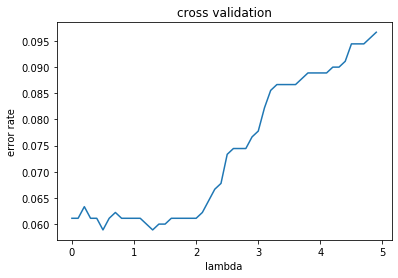

0.5

In [9]:
theta_to_plot = []

def K_fold(descent, K, lambd):
    n = np.shape(training_labels)[0]
    assert (n % K == 0)
    test_error = []
    for i in range(0, n, K):
            theta = descent(0.001*np.ones((pixel_height*pixel_width, 1)), 
                            np.concatenate([training_data[:i], training_data[i+K:n]]), 
                            np.concatenate([training_labels[:i], training_labels[i+K:n]]),
                            0.01, 100, lambd)
            
            test_error.append(test(theta, training_data[i:i+K], training_labels[i:i+K]))
    a = sum(test_error)/len(test_error)
    print(a)
    return a
                              
def choose_lambda (descent, K=90):
    l = np.array([K_fold(descent, K, i/10) for i in range(50)])
    plt.plot(np.arange(0, 5, 0.1), 1 - l, label="crossvalidation_error")
    plt.ylabel("error rate")
    plt.xlabel("lambda")
    plt.title("cross validation")
    plt.show(block=False)
    return np.argmax(l)/10
    

choose_lambda(gradient_descent_ridge)

## K means

In [ ]:
def PCA (data, space=2):
    m = np.mean(data, axis=1)
    data_centered -= np.reshape(m, (np.shape(m)[0], 1)) 
    w, v = np.linalg.eig(np.transpose(data_centered)@data_centered)
    w, v = np.unique(w, axis=0), np.unique(v, axis=0)
    basis = v[np.argsort(w)]
    return basis[:min(space, np.shape(basis)[0])]


def K_means (data, k, space, dist_function, epsilon):
    d = PCA(data)
    previous_means = d[:k]
    means = None
    while True: 
        clusters = [[] for i in range(k)]
        for x in d:
            index = np.argmin(dist_function(x, means))
            clusters[index].append(x)
        means = np.mean(clusters, axis=1)
        if np.max(means - previous_means) < epsilon: 
            return means, clusters
        
            
    